In [3]:
import sys
sys.path
sys.path.append('/volatile/aurelien_stumpf_mascles/project/code/')

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
import torch.nn as nn
import cebra_v2 as cebra2
from collections import defaultdict
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from torch.utils.data.sampler import BatchSampler
import package

## Fonctions utiles

In [2]:
def single_session_solver(data_loader, **kwargs):
    """Train a single session CEBRA model."""
    norm = True
    if kwargs['distance'] == 'euclidean':
        norm = False
    model = kwargs["model"]

    if kwargs['distance'] == 'euclidean':
        criterion = cebra2.criterion.EuclideanInfoNCE(temperature=kwargs['temperature'],beta = kwargs['beta'])
    elif kwargs['distance'] == 'cosine':        
        criterion = cebra2.criterion.CosineInfoNCE(temperature=kwargs['temperature'],beta = kwargs['beta'])

    optimizer = torch.optim.Adam(model.parameters(), lr=kwargs['learning_rate'])

    return cebra2.solver.SingleSessionSolver(model=model,
                                            criterion=criterion,
                                            optimizer=optimizer)

In [3]:
@torch.no_grad()
def get_emissions(model, dataset):
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    model.to(device)
    return model(dataset).cpu().numpy()

def _compute_emissions_single(solver, dataset):
    return get_emissions(solver.model, dataset)

## Data loading and preprocessing

In [4]:
loaded_arrays = np.load('/neurospin/lbi/monkeyfmri/deepstim/database/SYNTHETIC_database/sub-200_states-4_noise-high_synth/dataset.npz')
print(loaded_arrays.files)

['data25', 'dfc25', 'labels25', 'data30', 'dfc30', 'labels30', 'data35', 'dfc35', 'labels35', 'data40', 'dfc40', 'labels40', 'data45', 'dfc45', 'labels45', 'states']


In [5]:
dfc45 = torch.from_numpy(loaded_arrays['dfc45'])
labels45 = loaded_arrays["labels45"]
data45 = loaded_arrays['data45']
states = loaded_arrays['states']

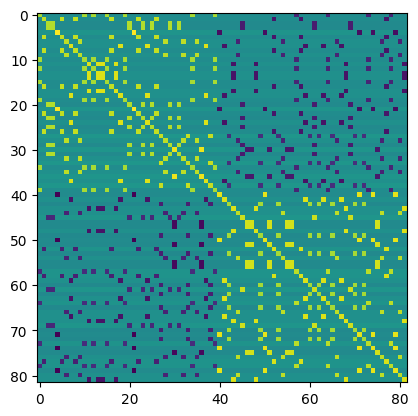

In [9]:
plt.imshow(states[0,:,:])

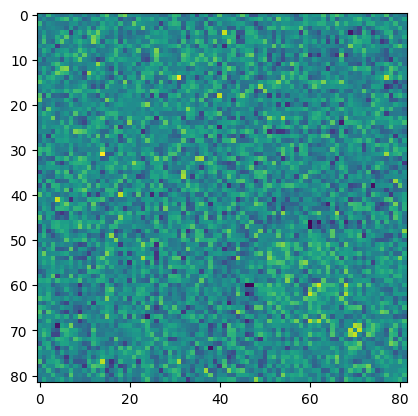

In [6]:
plt.imshow(dfc45[0,15,:,:])

In [6]:
dfc45.shape

torch.Size([200, 455, 82, 82])

In [7]:
labels_with_transition = package.preprocessing.create_labels_with_transitions(labels45)

In [8]:
fc_train = package.preprocessing.flatten_higher_triangular(dfc45[0:10,:,:,:])
fc_train = fc_train[0:10,:,:]
print(fc_train.shape)

(10, 455, 3321)


## PCA

In [9]:
a,b,c = fc_train.shape
pca = PCA(n_components=3)
pca.fit(fc_train.reshape(a*b,c))

PCA(n_components=3)

In [10]:
fc_transformed = np.zeros((a,b,3))
for i in range(a):
    fc_transformed[i,:,:] = pca.transform(fc_train[i,:,:])

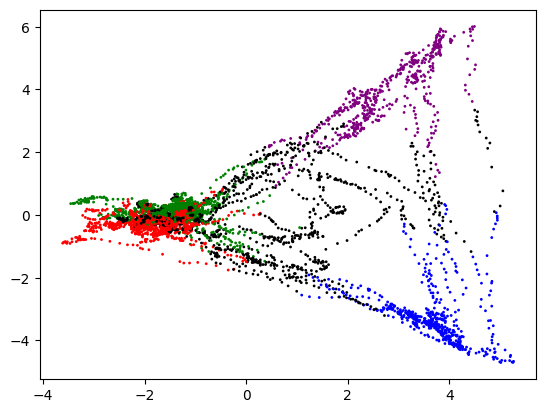

In [11]:
accu = fc_transformed.reshape((a*b,3))
labels = labels_with_transition[0:10,:].reshape(a*b)
colors = ["black",'red','green','blue','purple']
plt.scatter(accu[:,1], accu[:,2], cmap = matplotlib.colors.ListedColormap(colors), c = labels, s=1)

### Train a classifier on the reduced data

In [12]:
net = package.torch_classifier.MLP(input_dim = 3)
a,b,c = fc_transformed.shape
X = fc_transformed.reshape((a*b,c))[labels > 0]
y = labels[labels > 0]
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)
train = package.torch_classifier.SimpleDataset(X_train,y_train)
test = package.torch_classifier.SimpleDataset(X_test,y_test)
balanced_batch_sampler = package.torch_classifier.BalancedBatchSampler(train, n_classes = 4, n_samples = 10)
train_loader = torch.utils.data.DataLoader(train, batch_sampler = balanced_batch_sampler)
test_loader = torch.utils.data.DataLoader(test, batch_size=1000, shuffle=True, num_workers=6)

In [13]:
package.torch_classifier.Train(net,train_loader,test_loader,100)

[2529, 821, 2329, 2271, 6, 1447, 1923, 325, 1132, 1890, 1239, 530, 1587, 2416, 475, 409, 760, 1333, 2575, 669, 762, 247, 2674, 98, 46, 2478, 2292, 971, 54, 2702, 1141, 1143, 2273, 1103, 66, 1514, 1466, 2620, 932, 811]
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])


IndexError: Target 4 is out of bounds.

### Train a CEBRA model to improve the PCA embedding

In [19]:
num_output = 3
normalize = True
num_neurons = 3

model = cebra2.model.Model(
    nn.Linear(
        num_neurons,
        num_output * 5,
    ),
    nn.GELU(),
    nn.Linear(int(num_output * 5), num_output * 3),
    nn.GELU(),
    nn.Linear(int(num_output * 3), num_output),
    num_input=num_neurons,
    num_output=num_output,
    normalize = True
        )

In [20]:
distance = torch.from_numpy(package.preprocessing.generate_vector_distance(fc_transformed,distance="euclidean"))

0
1
2
3
4
5
6
7
8
9


(array([ 1023.,  2515.,  4799.,  7763., 10390., 11840., 12794., 13231.,
        13757., 13604., 13714., 12905., 12230., 12334., 12268., 12470.,
        12322., 12636., 13134., 13387., 13692., 13318., 13017., 12591.,
        12472., 12207., 11833., 11704., 11268., 11290., 11524., 11234.,
        11045., 10846., 11265., 11772., 11676., 11695., 11664., 11592.,
        11296., 11133., 11196., 11587., 11803., 12448., 12415., 12276.,
        12670., 12846., 13144., 13483., 13947., 14868., 15420., 16231.,
        16289., 16743., 17072., 17388., 17043., 16755., 15790., 14938.,
        14628., 14442., 13590., 13591., 13495., 13151., 13169., 12770.,
        11936., 10431.,  9198.,  8210.,  7579.,  6605.,  5991.,  5464.,
         4838.,  3955.,  3268.,  2938.,  2483.,  2238.,  1799.,  1485.,
         1458.,  1201.,  1127.,  1000.,   798.,   774.,   414.,   182.,
           92.,    51.,    26.,    21.]),
 array([ 0.        ,  0.11122401,  0.22244801,  0.33367202,  0.44489602,
         0.55612003, 

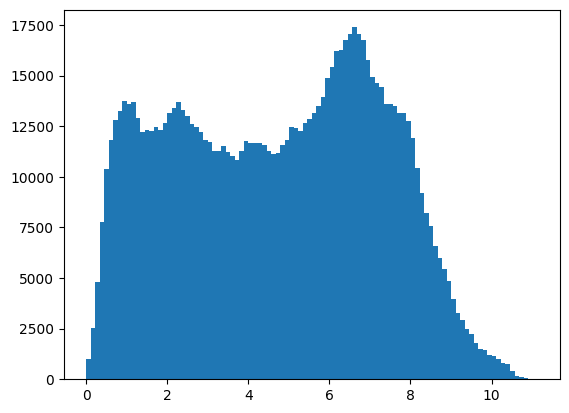

In [21]:
plt.hist(distance.flatten()[:1000000],bins=100)

In [22]:
fc_dataset = cebra2.dataset.SimpleMultiSessionDataset(fc_transformed)
fc_loader = cebra2.dataset.MultiSessionLoader(fc_dataset, num_steps = 1000, batch_size = 2048,  distance = distance, time_delta = 20, matrix_delta = 4)

In [23]:
cebra_fc = single_session_solver(data_loader = fc_loader, model_architecture = 'offset1-model', 
                 distance = 'cosine', num_hidden_units = 128, output_dimension = 128,
                verbose = True, temperature = 1, beta = 1,learning_rate = 3e-4, model = model)

In [24]:
cebra_fc.fit(fc_loader)

Epoch 0
Train loss 7.3502, Train accuracy 0.00%
Epoch 100
Train loss 6.9988, Train accuracy 0.00%
Epoch 200
Train loss 6.9771, Train accuracy 0.00%
Epoch 300
Train loss 6.9797, Train accuracy 0.00%
Epoch 400
Train loss 6.9737, Train accuracy 0.00%
Epoch 500
Train loss 6.9584, Train accuracy 0.00%
Epoch 600
Train loss 6.9762, Train accuracy 0.00%
Epoch 700
Train loss 6.9720, Train accuracy 0.00%
Epoch 800
Train loss 6.9575, Train accuracy 0.00%
Epoch 900
Train loss 6.9682, Train accuracy 0.00%


(-1.0996659457683564,
 1.0937086999416352,
 -0.705794295668602,
 1.0809668511152268)

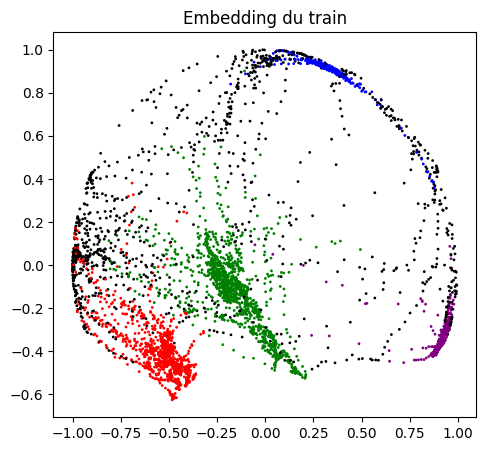

In [132]:
a,b,c = fc_dataset.neural.shape
data_print = fc_dataset.neural.reshape(a*b,c)
fc_emb = _compute_emissions_single(cebra_fc, data_print)
fig = plt.figure(figsize = (12,5))

ax1 = plt.subplot(121)
ax1.set_title('Embedding du train')
colors = ["black",'red','green','blue','purple']
ax1.scatter(fc_emb[:,0], fc_emb[:,2], cmap = matplotlib.colors.ListedColormap(colors), c = labels, s=1)
#ax1.xticks() 
ax1.axis('on')

In [133]:
net = package.torch_classifier.MLP(input_dim=3)
X = fc_emb[labels > 0]
y = y = labels[labels > 0]
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26)
train = package.torch_classifier.SimpleDataset(X_train,y_train)
test = package.torch_classifier.SimpleDataset(X_test,y_test)
balanced_batch_sampler = package.torch_classifier.BalancedBatchSampler(train, n_classes = 4, n_samples = 4)
train_loader = torch.utils.data.DataLoader(train, batch_sampler = balanced_batch_sampler)
test_loader = torch.utils.data.DataLoader(test, batch_size=1000, shuffle=True, num_workers=6)

In [134]:
package.torch_classifier.Train(net,train_loader,test_loader,100)

Train loss 0.0168, Train accuracy 96.37%
Test accuracy 68.90%
Train loss 0.0001, Train accuracy 100.00%
Test accuracy 69.00%
Train loss 0.0000, Train accuracy 100.00%
Test accuracy 69.00%
Train loss 0.0000, Train accuracy 100.00%
Test accuracy 69.00%
Train loss 0.0000, Train accuracy 100.00%
Test accuracy 69.00%
Train loss 0.0000, Train accuracy 100.00%
Test accuracy 69.00%
Train loss 0.0000, Train accuracy 100.00%
Test accuracy 69.00%
Train loss 0.0000, Train accuracy 100.00%
Test accuracy 69.00%
Train loss 0.0000, Train accuracy 100.00%
Test accuracy 69.00%
Train loss 0.0000, Train accuracy 100.00%
Test accuracy 69.00%
End of training.



(-1.0996659457683564,
 1.0937086999416352,
 -1.0998521238565444,
 1.0997047215700149)

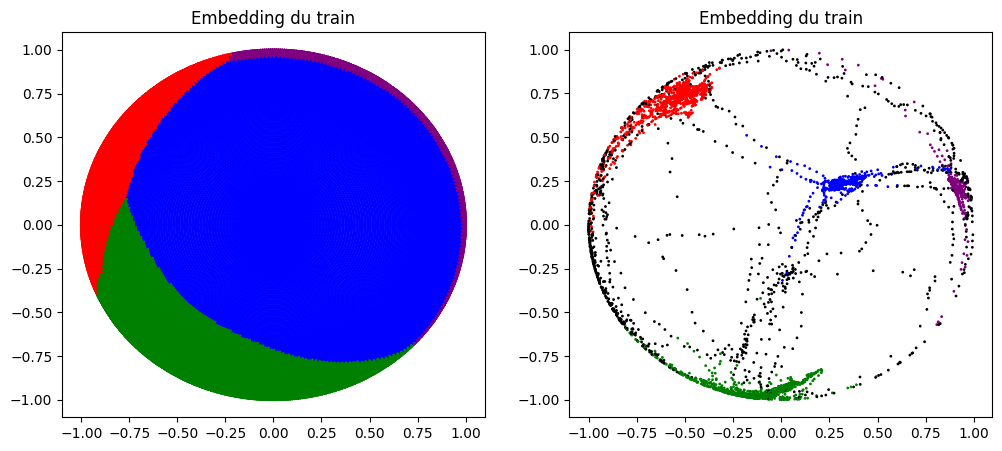

In [135]:
a,b = np.meshgrid(np.linspace(0,2*np.pi,300),np.linspace(0,np.pi,200))
x = (np.cos(a)*np.cos(b)).reshape(-1,1)
y = (np.sin(a)*np.cos(b)).reshape(-1,1)
z = np.sin(b).reshape(-1,1)
sphere = np.concatenate((x,y,z),axis = 1)

net.eval()
probas = torch.exp(net(torch.from_numpy(sphere).type(torch.float32)))
res = torch.argmax(probas,dim=1)+1

fig = plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.set_title('Embedding du train')
colors = ["black",'red','green','blue','purple']
ax1.scatter(sphere[:,0], sphere[:,1], cmap = matplotlib.colors.ListedColormap(colors[1:]), c = res, s=1)
#ax1.xticks() 
ax1.axis('on')

ax2 = plt.subplot(122)
ax2.set_title('Embedding du train')
colors = ["black",'red','green','blue','purple']
ax2.scatter(fc_emb[:,0], fc_emb[:,1], cmap = matplotlib.colors.ListedColormap(colors), c = labels, s=1)
#ax1.xticks() 
ax2.axis('on')

(-1.0996659457683564,
 1.0937086999416352,
 -1.0998521238565444,
 1.0997047215700149)

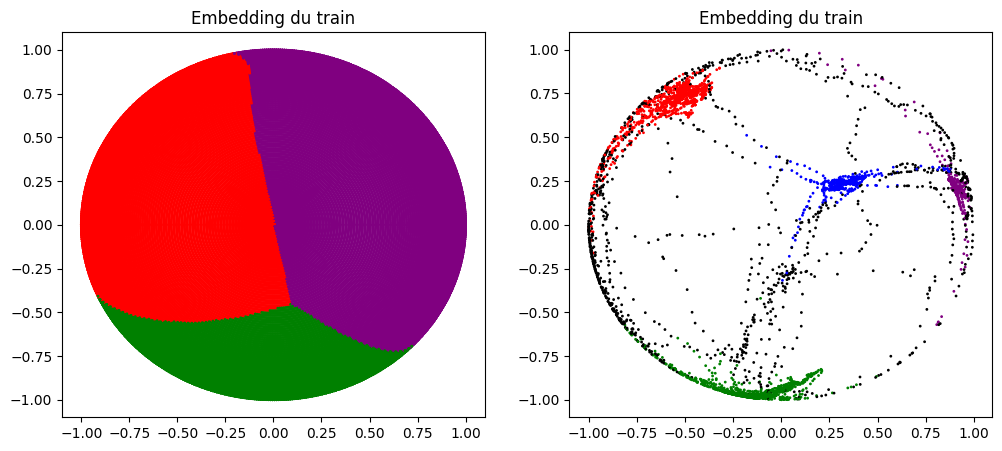

In [136]:
a,b = np.meshgrid(np.linspace(0,2*np.pi,300),-np.linspace(0,np.pi,200))
x = (np.cos(a)*np.cos(b)).reshape(-1,1)
y = (np.sin(a)*np.cos(b)).reshape(-1,1)
z = np.sin(b).reshape(-1,1)
sphere = np.concatenate((x,y,z),axis = 1)

net.eval()
probas = torch.exp(net(torch.from_numpy(sphere).type(torch.float32)))
res = torch.argmax(probas,dim=1)+1

fig = plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.set_title('Embedding du train')
colors = ["black",'red','green','blue','purple']
ax1.scatter(sphere[:,0], sphere[:,1], cmap = matplotlib.colors.ListedColormap(colors[1:]), c = res, s=1)
#ax1.xticks() 
ax1.axis('on')

ax2 = plt.subplot(122)
ax2.set_title('Embedding du train')
colors = ["black",'red','green','blue','purple']
ax2.scatter(fc_emb[:,0], fc_emb[:,1], cmap = matplotlib.colors.ListedColormap(colors), c = labels, s=1)
#ax1.xticks() 
ax2.axis('on')